In [ ]:
import os
import json
import logging
from typing import List
from string import Template

from dotenv import load_dotenv
from sqlalchemy import create_engine
from pydantic import TypeAdapter
from google.genai import Client

from src import prompts
from src import utils
from src import schemas
from src import batch

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
load_dotenv();

In [4]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(name)s: %(message)s")

In [5]:
connection_string = (
    "postgresql://{user}:{password}@{host}:{port}/{db}".format(
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        host=os.getenv("DB_HOST"),
        port=os.getenv("DB_PORT"),
        db=os.getenv("DB_NAME"),
    )
)
engine = create_engine(connection_string)

In [ ]:
official_website_finder_instructions = Template("""You are given a name of a paragliding site. Your goal is to search the web and try to find an official websites related to the site.

Instructions:
- Search the web to find the official website.
- Use search queries in the language of the country the site is located in.
- Make sure to use the most recent information available. The current date is $current_date.
- Identify the official websites from the search results. These may be websites operated by an owner, local club or school or another authority related to the site.
- The website needs to provide comprehensive infromation about the site and its operations. It should provide at least some of the following:
    - Descriptions of takeoff and landing areas
    - Specific local rules and regulations
    - Fees (if any)
    - Access to the site
    - Local meteostation and webcams
    - Any other information that is relevant to the site
- Sometimes a club's website may provide information about mulitple nearby sites. That is fine, you can return such a website if it provides information about the site you are looking for.
- However, do NOT report websites that aggregate information about many sites not being directly related to them such as Paragliding Maps (paraglidingmap.com, paraglidingearth.com etc.), weather websites, social media pages, forums, etc.
- If you find multiple official websites, return ALL of them.
                        

Format:
- Your response should be a JSON object that is a list of dictionaries.
- Each dictionary in the list should have two keys: 'url' and 'description'.
- The value associated with the 'url' key should be a string representing a website URL.
- The value associated with the 'description' key should be a brief string describing the website.
- If you don't find any official website, return an empty list.
- Do not include any other text in your response.

Example:
Site: Dune du Pyla
```json
[
  {
    "url": "https://pylavollibre33260.wixsite.com/pyla-vol-libre",
    "description": "Official website of La Teste Pyla Vol Libre, a local paragliding club associated with the French Free Flight Federation (FFVL)."
  },
  {
    "url": "https://parapilat.com/",
    "description": "Official online information platform for paragliding regulations at the Dune du Pilat, outlining rules and guidelines for pilots and professionals."
  },
  {
    "url": "https://www.dunedupilat.com/",
    "description": "Official website for the Dune du Pilat, managed by the Syndicat Mixte de la Grande Dune du Pilat, providing general information about the site, including a section on paragliding."
  }
]
```

Site: $site_details
""")

In [6]:
sites = utils.get_sites(engine)
client = Client(api_key=os.getenv("GOOGLE_API_KEY"))

In [ ]:
def build_requests(site_ids: list[int]) -> list[dict]:
    return batch.build_requests_for_site_ids(site_ids, sites, official_website_finder_instructions, engine)

In [8]:
# Iteratively retry via generalized batch module
JOB_NAME = "gemini_official_website_finder"

all_site_ids = list(sites["site_id"].astype(int).values)

resolved, unresolved = batch.run_iterative_batch(
    client=client,
    items=all_site_ids,
    build_requests_fn=build_requests,
    parse_result_fn=batch.parse_result_google_text,
    job_name_prefix=JOB_NAME,
    max_retries=10,
    poll_interval_sec=30,
)

print(f"Resolved: {len(resolved)}  Unresolved: {len(unresolved)}")

# Ensure batch_results directory exists
import os
os.makedirs("../batch_results", exist_ok=True)

# Persist results keyed by site_id
ok_out = f"../batch_results/{JOB_NAME}_final_results.jsonl"
with open(ok_out, "w", encoding="utf-8") as f:
    for sid in sorted(resolved.keys()):
        result = resolved[sid]
        f.write(json.dumps({
            "site_id": int(sid),
            "text": result["text"],
            "usageMetadata": result["usageMetadata"]
        }, ensure_ascii=False) + "\n")

# Persist unresolved site_ids for inspection/resubmission
failed_out = f"../batch_results/{JOB_NAME}_unresolved_site_ids.json"
with open(failed_out, "w") as f:
    json.dump(sorted([int(x) for x in unresolved]), f)

2025-11-05 13:27:14,663 INFO src.batch: Attempt 1: processing 248 items
2025-11-05 13:27:17,999 INFO src.batch: Submitting batch 'gemini_official_website_finder_attempt_1-1762345634' with 248 requests
2025-11-05 13:27:18,814 INFO httpx: HTTP Request: POST https://generativelanguage.googleapis.com/upload/v1beta/files "HTTP/1.1 200 OK"
2025-11-05 13:27:20,033 INFO httpx: HTTP Request: POST https://generativelanguage.googleapis.com/upload/v1beta/files?upload_id=AOCedOH8kOp1CbXYcoNV9_QnTagA43o_fNFjH9XHSKC4VBJ8dxzAaixL9Ofrd_TMUvVSKqSnaE2ObXXAXkE_g0VoFw4tthM6Lo150O-E7Djh6Q&upload_protocol=resumable "HTTP/1.1 200 OK"
2025-11-05 13:27:22,225 INFO httpx: HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro:batchGenerateContent "HTTP/1.1 200 OK"
2025-11-05 13:27:22,227 INFO src.batch: Created batch job 'batches/sr8p33dxwrjyves2w919nyvz9c9atie2ijhz' (model=gemini-2.5-pro)
2025-11-05 13:27:22,408 INFO httpx: HTTP Request: GET https://generativelanguage.googleap

Resolved: 248  Unresolved: 0


In [16]:
resolved

{1: {'text': '```json\n[\n  {\n    "url": "https://www.rana-paragliding.cz/",\n    "description": "Official website of the Paragliding klub Raná, providing comprehensive information for pilots about the Raná site, including current conditions, events, and club information."\n  },\n  {\n    "url": "https://www.aeroklubrana.cz/",\n    "description": "Official website of the Aeroklub Raná, which operates the public domestic airport at Raná. The website provides information about the airport\'s operations, which is relevant for paraglider pilots flying in the vicinity."\n  },\n  {\n    "url": "https://www.kurzy-paragliding.cz/",\n    "description": "Website for Základní škola létání (Basic Flying School), a paragliding school that has been operating at Raná for over 20 years. It provides information about their courses and tandem flights at the site."\n  }\n]\n```',
  'usageMetadata': {'toolUsePromptTokenCount': 8353,
   'thoughtsTokenCount': 1381,
   'candidatesTokenCount': 534,
   'cache

In [13]:
import re
import json

def parse_text_field_to_dict(obj):
    """
    Takes a dict with a 'text' key containing a markdown code block (with JSON inside)
    and returns the parsed Python object (usually a list of dicts).
    """
    text = obj.get('text', '')
    # Extract content between ```json and ```
    match = re.search(r"```json\s*([\s\S]*?)\s*```", text)
    if match:
        json_str = match.group(1)
    else:
        # fallback: just use whole string
        json_str = text
    # Remove leading/trailing whitespace/newlines
    json_str = json_str.strip()
    # Remove excess code fences if present
    if json_str.startswith("```") and json_str.endswith("```"):
        json_str = json_str[3:-3].strip()
    try:
        return json.loads(json_str)
    except Exception:
        # Fallback: try to find a bracketed JSON structure in the string
        bracket_match = re.search(r"(\[.*\])", json_str, re.DOTALL)
        if bracket_match:
            try:
                return json.loads(bracket_match.group(1))
            except Exception:
                pass
        return None

In [15]:
for site_id, result in resolved.items():
    data = parse_text_field_to_dict(result)
    print(data)

[{'url': 'https://www.rana-paragliding.cz/', 'description': 'Official website of the Paragliding klub Raná, providing comprehensive information for pilots about the Raná site, including current conditions, events, and club information.'}, {'url': 'https://www.aeroklubrana.cz/', 'description': "Official website of the Aeroklub Raná, which operates the public domestic airport at Raná. The website provides information about the airport's operations, which is relevant for paraglider pilots flying in the vicinity."}, {'url': 'https://www.kurzy-paragliding.cz/', 'description': 'Website for Základní škola létání (Basic Flying School), a paragliding school that has been operating at Raná for over 20 years. It provides information about their courses and tandem flights at the site.'}]


In [28]:
import pandas as pd

import requests

def validate_url(url, timeout=5):
    """
    Returns True if the URL responds with HTTP status (and loads), else False.
    """
    print(url)
    try:
        # HEAD faster, but some servers do not support it; fallback to GET
        try:
            response = requests.head(url, timeout=timeout, allow_redirects=True)
            if response.status_code < 400:
                return True
        except Exception:
            # If HEAD failed, fall through to GET
            response = requests.get(url, timeout=timeout, allow_redirects=True)
            if response.status_code < 400:
                return True
        return False
    except Exception:
        return False

# Parse resolved into dataframe
rows = []
for site_id, result in resolved.items():
    # Parse the text to extract URLs
    parsed_data = parse_text_field_to_dict(result)
    urls = [item.get('url') for item in parsed_data] if parsed_data else []
    
    # Validate URLs
    valid_urls = []
    invalid_urls = []
    for url in urls:
        if validate_url(url):
            valid_urls.append(url)
        else:
            invalid_urls.append(url)
    
    # Extract usage metadata
    usage = result.get('usageMetadata', {})
    
    # Extract toolTokenCount from toolUsePromptTokensDetails (which is a list)
    tool_details = usage.get('toolUsePromptTokensDetails', [])
    if isinstance(tool_details, list) and len(tool_details) > 0:
        tool_token_count = tool_details[0].get('tokenCount', 0)
    else:
        tool_token_count = 0
    
    row = {
        'site_id': int(site_id),
        'urls': urls,
        'url_cnt': len(urls),
        'valid_urls': valid_urls,
        'invalid_urls': invalid_urls,
        'valid_urls_cnt': len(valid_urls),
        'invalid_urls_cnt': len(invalid_urls),
        'thoughtsTokenCount': usage.get('thoughtsTokenCount', 0),
        'candidatesTokenCount': usage.get('candidatesTokenCount', 0),
        'cachedContentTokenCount': usage.get('cachedContentTokenCount', 0),
        'promptTokenCount': usage.get('promptTokenCount', 0),
        'totalTokenCount': usage.get('totalTokenCount', 0),
        'toolTokenCount': tool_token_count
    }
    rows.append(row)

df = pd.DataFrame(rows)
df

https://www.rana-paragliding.cz/
https://www.aeroklubrana.cz/
https://www.kurzy-paragliding.cz/
https://www.chciletat.cz/provozni-rad-trinec-javorovy-vrch/
https://javorovy-vrch.cz/paragliding/
https://www.elspeedo.cz/
https://www.paragliding-kozakov.cz/
https://pgbaraka.cz/tereny/kozak/
https://www.pgcernahora.cz/
http://pgkrupka.cz/
https://www.paragliding-sumava.cz/
https://www.blk-pg.cz/startoviste/ondrejnik-skalka/
https://www.pghnizdo.cz/letovy-teren-ondrejnik-skalka/
https://pgplzen.cz/
http://www.paragliding-uhrinov.cz/
http://jevinka.wz.cz/
http://pgkrupka.com/
http://www.blk-pg.cz/startoviste/velky-javornik/
https://pgplzen.cz/
https://www.pgsumava.cz/
https://www.baraka-paragliding.cz/tereny/rasovka/
https://www.pgkrupka.cz/
https://www.x-air.sk/Tereny/Stranik/
https://www.x-air.sk/tereny/donovaly/
https://www.parksnow.sk/leto/aktivity/paragliding
https://www.pgskola.sk/tereny/horna-suca/
https://www.x-air.sk/tereny/martinske-hole/
https://www.x-air.sk/tereny/kubinska-hola/


,site_id,urls,url_cnt,valid_urls,invalid_urls,valid_urls_cnt,invalid_urls_cnt,thoughtsTokenCount,candidatesTokenCount,cachedContentTokenCount,promptTokenCount,totalTokenCount,toolTokenCount
0,1,"[https://www.rana-paragliding.cz/, https://www...",3,[https://www.rana-paragliding.cz/],"[https://www.aeroklubrana.cz/, https://www.kur...",1,2,1381,534,250,785,11053,8353
1,2,[https://www.chciletat.cz/provozni-rad-trinec-...,3,"[https://javorovy-vrch.cz/paragliding/, https:...",[https://www.chciletat.cz/provozni-rad-trinec-...,2,1,948,427,270,758,6146,4013
2,3,"[https://www.paragliding-kozakov.cz/, https://...",2,[https://pgbaraka.cz/tereny/kozak/],[https://www.paragliding-kozakov.cz/],1,1,1568,435,484,721,10542,7818
3,4,[https://www.pgcernahora.cz/],1,[https://www.pgcernahora.cz/],[],1,0,593,143,0,723,2834,1375
4,5,[http://pgkrupka.cz/],1,[http://pgkrupka.cz/],[],1,0,584,139,0,719,2390,948
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,248,[https://nyikom.hu/index.php/hu/sikloernyos-st...,2,[http://nyikom.gportal.hu/gindex.php?pg=32957438],[https://nyikom.hu/index.php/hu/sikloernyos-st...,1,1,523,212,0,716,2369,918
244,249,[http://gyssk2001.tar.hu/sarhegy.htm],1,[],[http://gyssk2001.tar.hu/sarhegy.htm],0,1,507,143,0,682,2232,900
245,250,[],0,[],[],0,0,796,195,417,718,6675,4966
246,134,[https://www.cornizzolo.it/],1,[https://www.cornizzolo.it/],[],1,0,1312,119,0,794,4376,2151


In [36]:
print("Invalid URLs percentage:", round(df["invalid_urls_cnt"].sum() / df["url_cnt"].sum(), 2))
print("Percentage of sites without any valid URLs:", round(df[df["valid_urls_cnt"] == 0].shape[0] / df.shape[0], 2))

Invalid URLs percentage: 0.52
Percentage of sites without any valid URLs: 0.37


<Axes: ylabel='Frequency'>

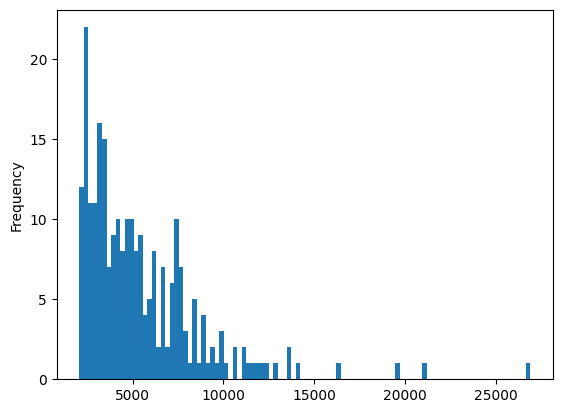

In [40]:
df["totalTokenCount"].plot(kind="hist", bins=100)